In [43]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

1 Pré-traitement

1.1 Obtention des marqueurs

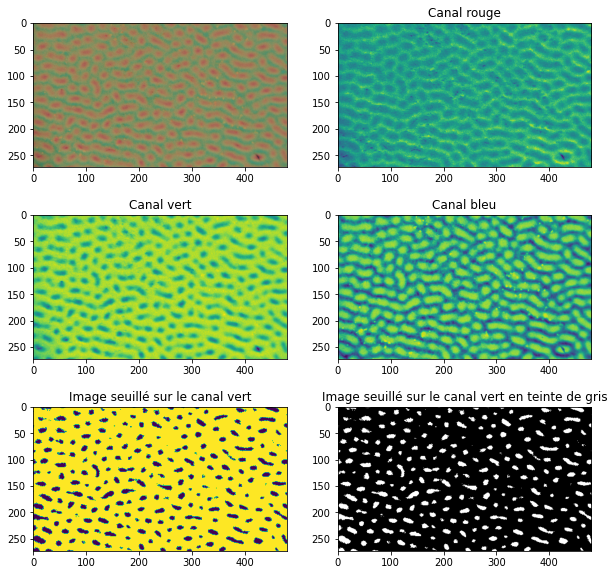

In [44]:
#Lecture de l’image (en niveau de gris)
I=cv2.imread('perovskyte.png')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10)) # ouvre une nouvelle figure
plt.subplot(321)
plt.imshow(I) # affichage de l'image I en niveau de gris


# Separation de l'image
B, G, R = cv2.split(I)

img_g = G
# Seuillage de la composante verte
image_seuille = cv2.threshold(img_g, 120, 255, cv2.THRESH_BINARY)

image_seuille_gris = cv2.threshold(image_seuille[1], 250, 255, cv2.THRESH_BINARY_INV)


#Affichage des caneaux RGB et des images seuillé et en n & b
plt.subplot(322)
plt.title('Canal rouge')
plt.imshow(R)

plt.subplot(323)
plt.title('Canal vert')
plt.imshow(G)

plt.subplot(324)
plt.title('Canal bleu')
plt.imshow(B)

plt.subplot(325)
plt.title('Image seuillé sur le canal vert')
plt.imshow(image_seuille[1])


plt.subplot(326)
plt.title('Image seuillé sur le canal vert en teinte de gris')
plt.imshow(image_seuille_gris[1], 'gray') 

plt.show()


#afficher les caneaux rgb et trouver un maniere d'obtenir mon image de marquer dans chaque cellule

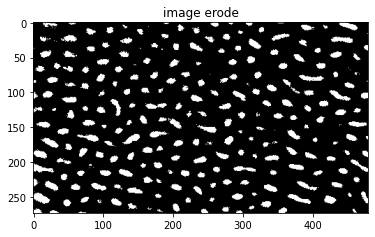

In [45]:
#Isolation d'un marqueur unique dans chaque bonbon
S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1)) #création d'un élément structurant circulaire

E=cv2.erode(image_seuille_gris[1], S, iterations = 1) # n érosions successives de I par S

plt.figure() # ouvre une nouvelle figure
plt.title("image erode")
plt.imshow(E,'gray') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage

295 0


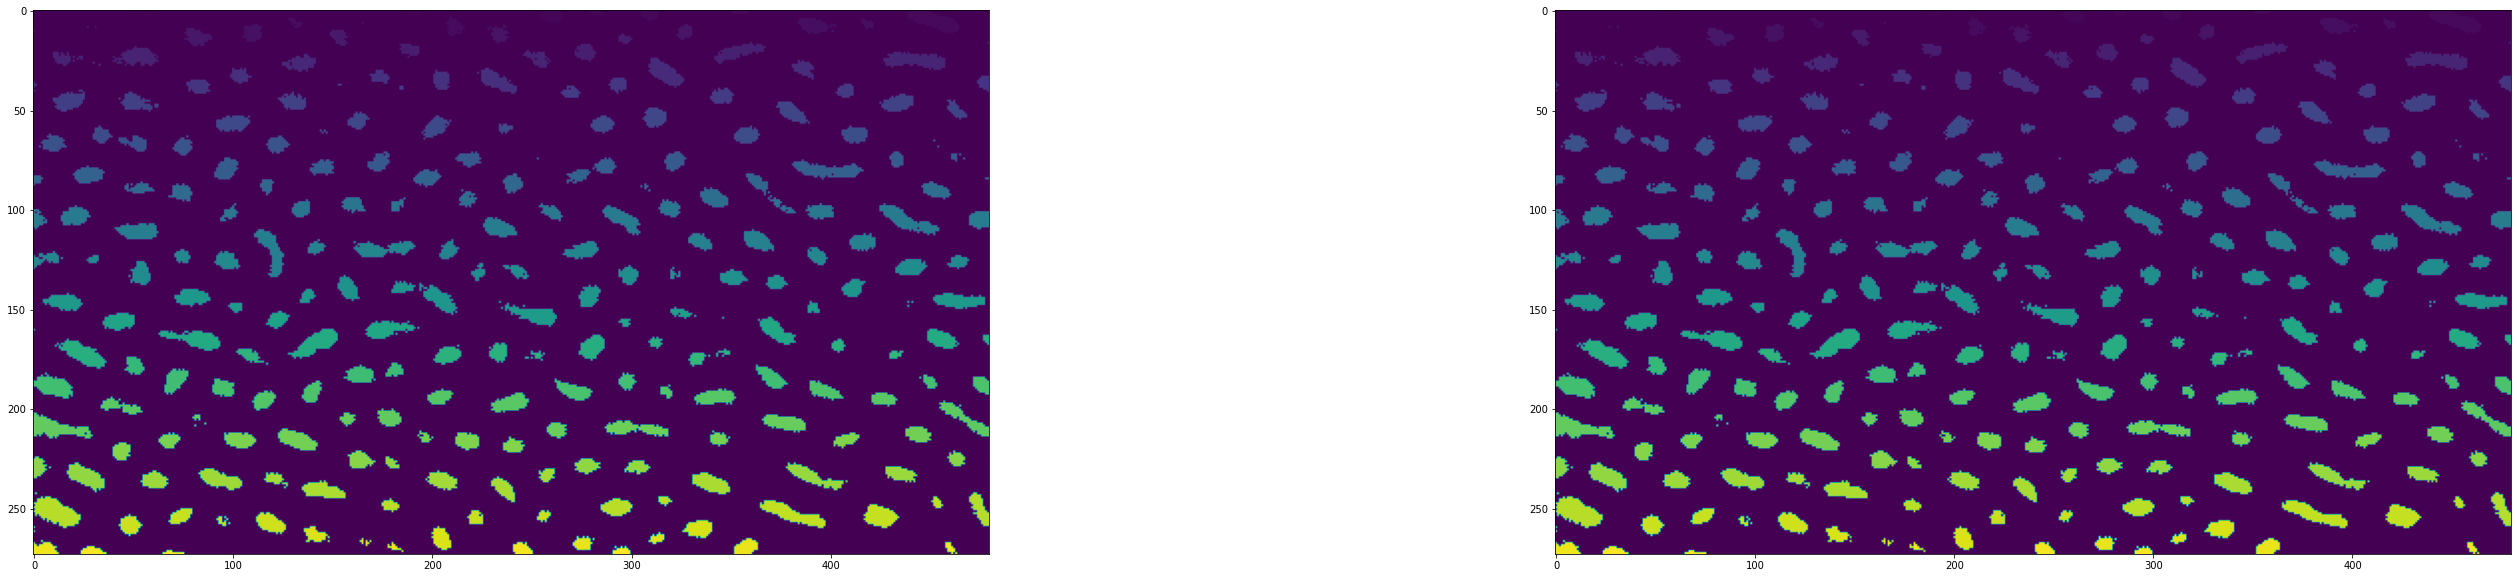

In [46]:
#Attribution des labels
label1= cv2.connectedComponents(E)


plt.figure(figsize=(50,10)) # ouvre une nouvelle figure
plt.subplot(121)
plt.imshow(label1[1]) # affichage des labels


#Seuillage du fond de l'image
u = np.max(label1[1])
v = np.min(label1[1])
print(u,v)

image_seuille2=cv2.threshold(I, 250, 296, cv2.THRESH_BINARY) #dans variables, on voit que le max vaut 33 donc on fixe le fond a 33

image_finale= image_seuille2[0]+label1[1]

plt.subplot(122)
plt.imshow(image_finale) # image-seuillé est ne liste d'images
plt.show()



1.2 Obtention de la carte des distances

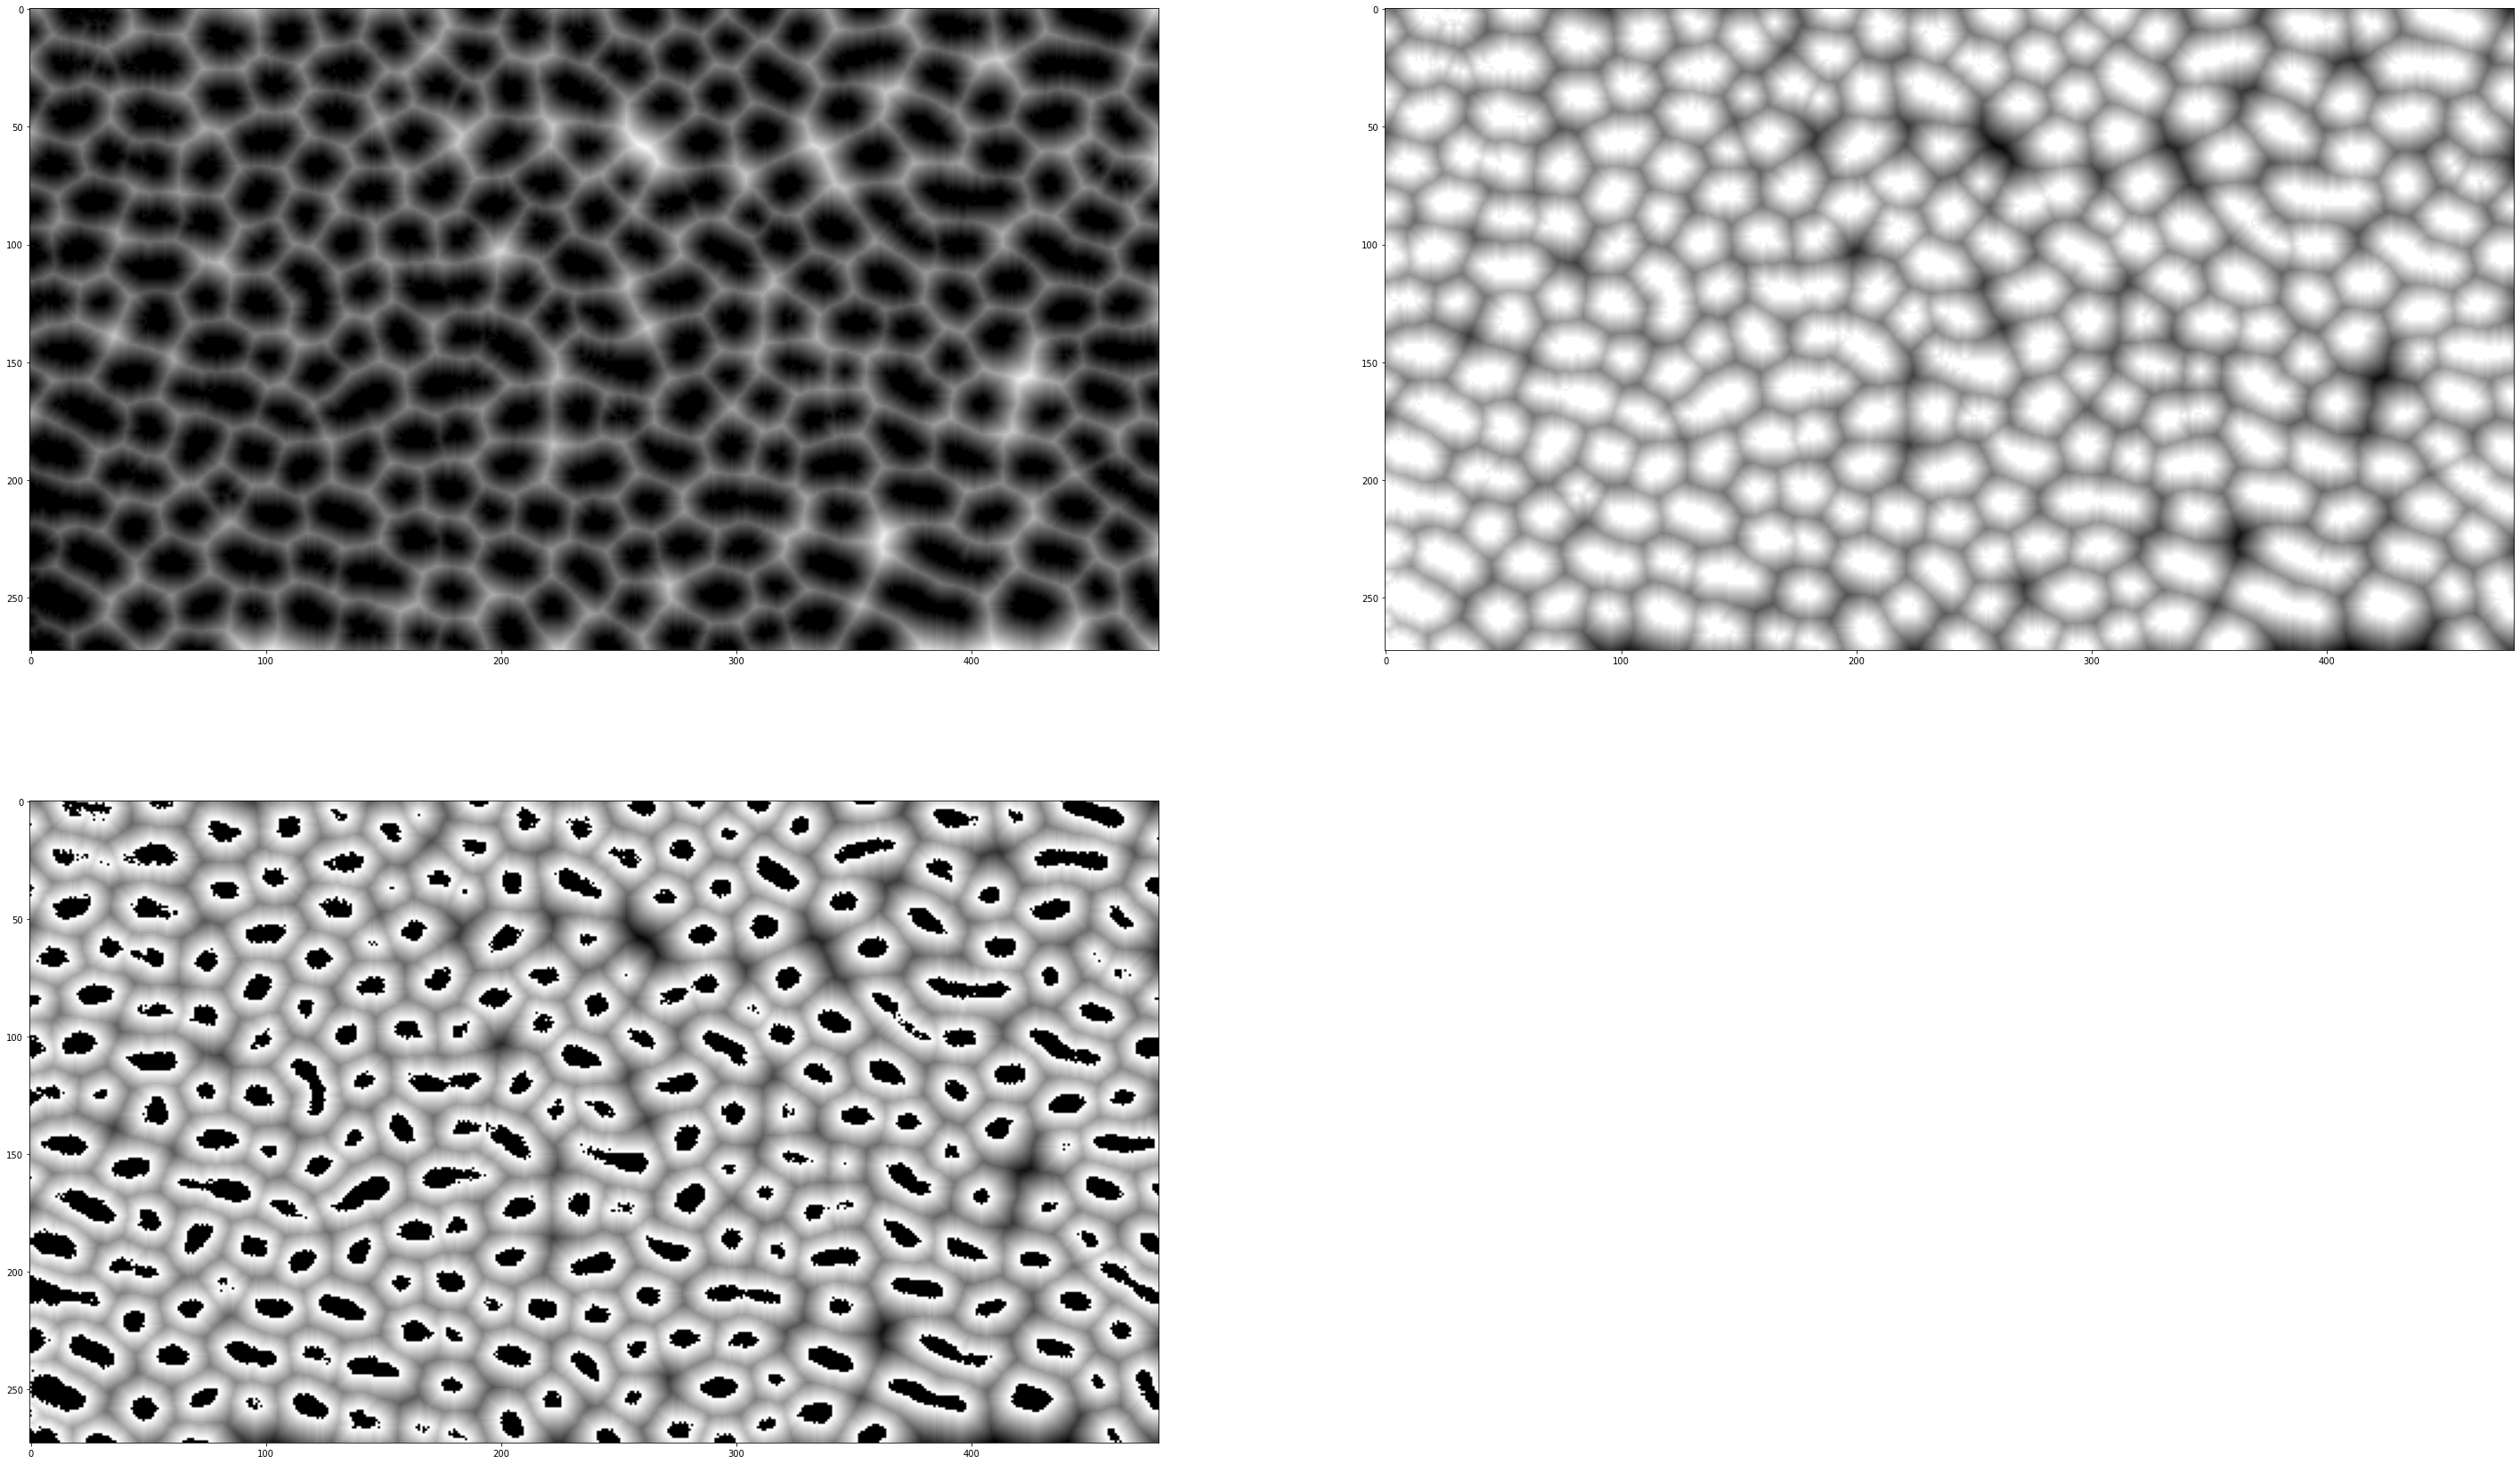

In [47]:
Dist=cv2.distanceTransform(image_seuille[1], cv2.DIST_L2, 3, cv2.CV_32F ) # pour le calcul de la carte de distance

plt.figure(figsize=(50,30)) # ouvre une nouvelle figure
plt.subplot(221)
plt.imshow(Dist,'gray') # affichage de l'image I en niveau de gris

Dist_norm= (Dist*255)/np.max(Dist)  #on verifie grace a cette ligne que la carte aut des valeurs entieres comprise en tre 0 et 255

Dist_inv=255-Dist_norm #inverser l'image normalisé
Dist_inv_norm= (Dist_inv*255)/np.max(Dist_inv)  #on verifie grace a cette ligne que la carte aut des valeurs entieres comprise en tre 0 et 255


plt.subplot(222)
plt.imshow(Dist_inv,'gray') # affichage de l'image I en niveau de gris


image_finale2=Dist_inv*image_seuille[1]
image_finale2_norm= (image_finale2*255)/np.max(image_finale2) #on normalise l'image pour qu'elle aille entre 0 et 255
image_finale2_norm_int=np.uint8(image_finale2_norm) #on transforme l'image pour qu'elle soit composé que d'entier
min =np.min(image_finale2_norm_int) #on verifie que le min vaille 0
max=np.max(image_finale2_norm_int) #on verifie que le max vaille 0

plt.subplot(223)
plt.imshow(image_finale2_norm_int,'gray') # affichage de l'image I en niveau de gris
plt.show()

#On obtient une image qu'il faut visualiser en 3D pour bien comprendre ce que l'on fait . en noir c'est la mer
#chaque bonbons est une ile qui ressemble a unevalaise en rond. La LPE consista a rempir par le bas chaque montagne
#la priorité des bonbons correspond aux bonbons qui se remplissent en premier soit ceux qui on plus de noir au centre. 

2 Algorithme LPE

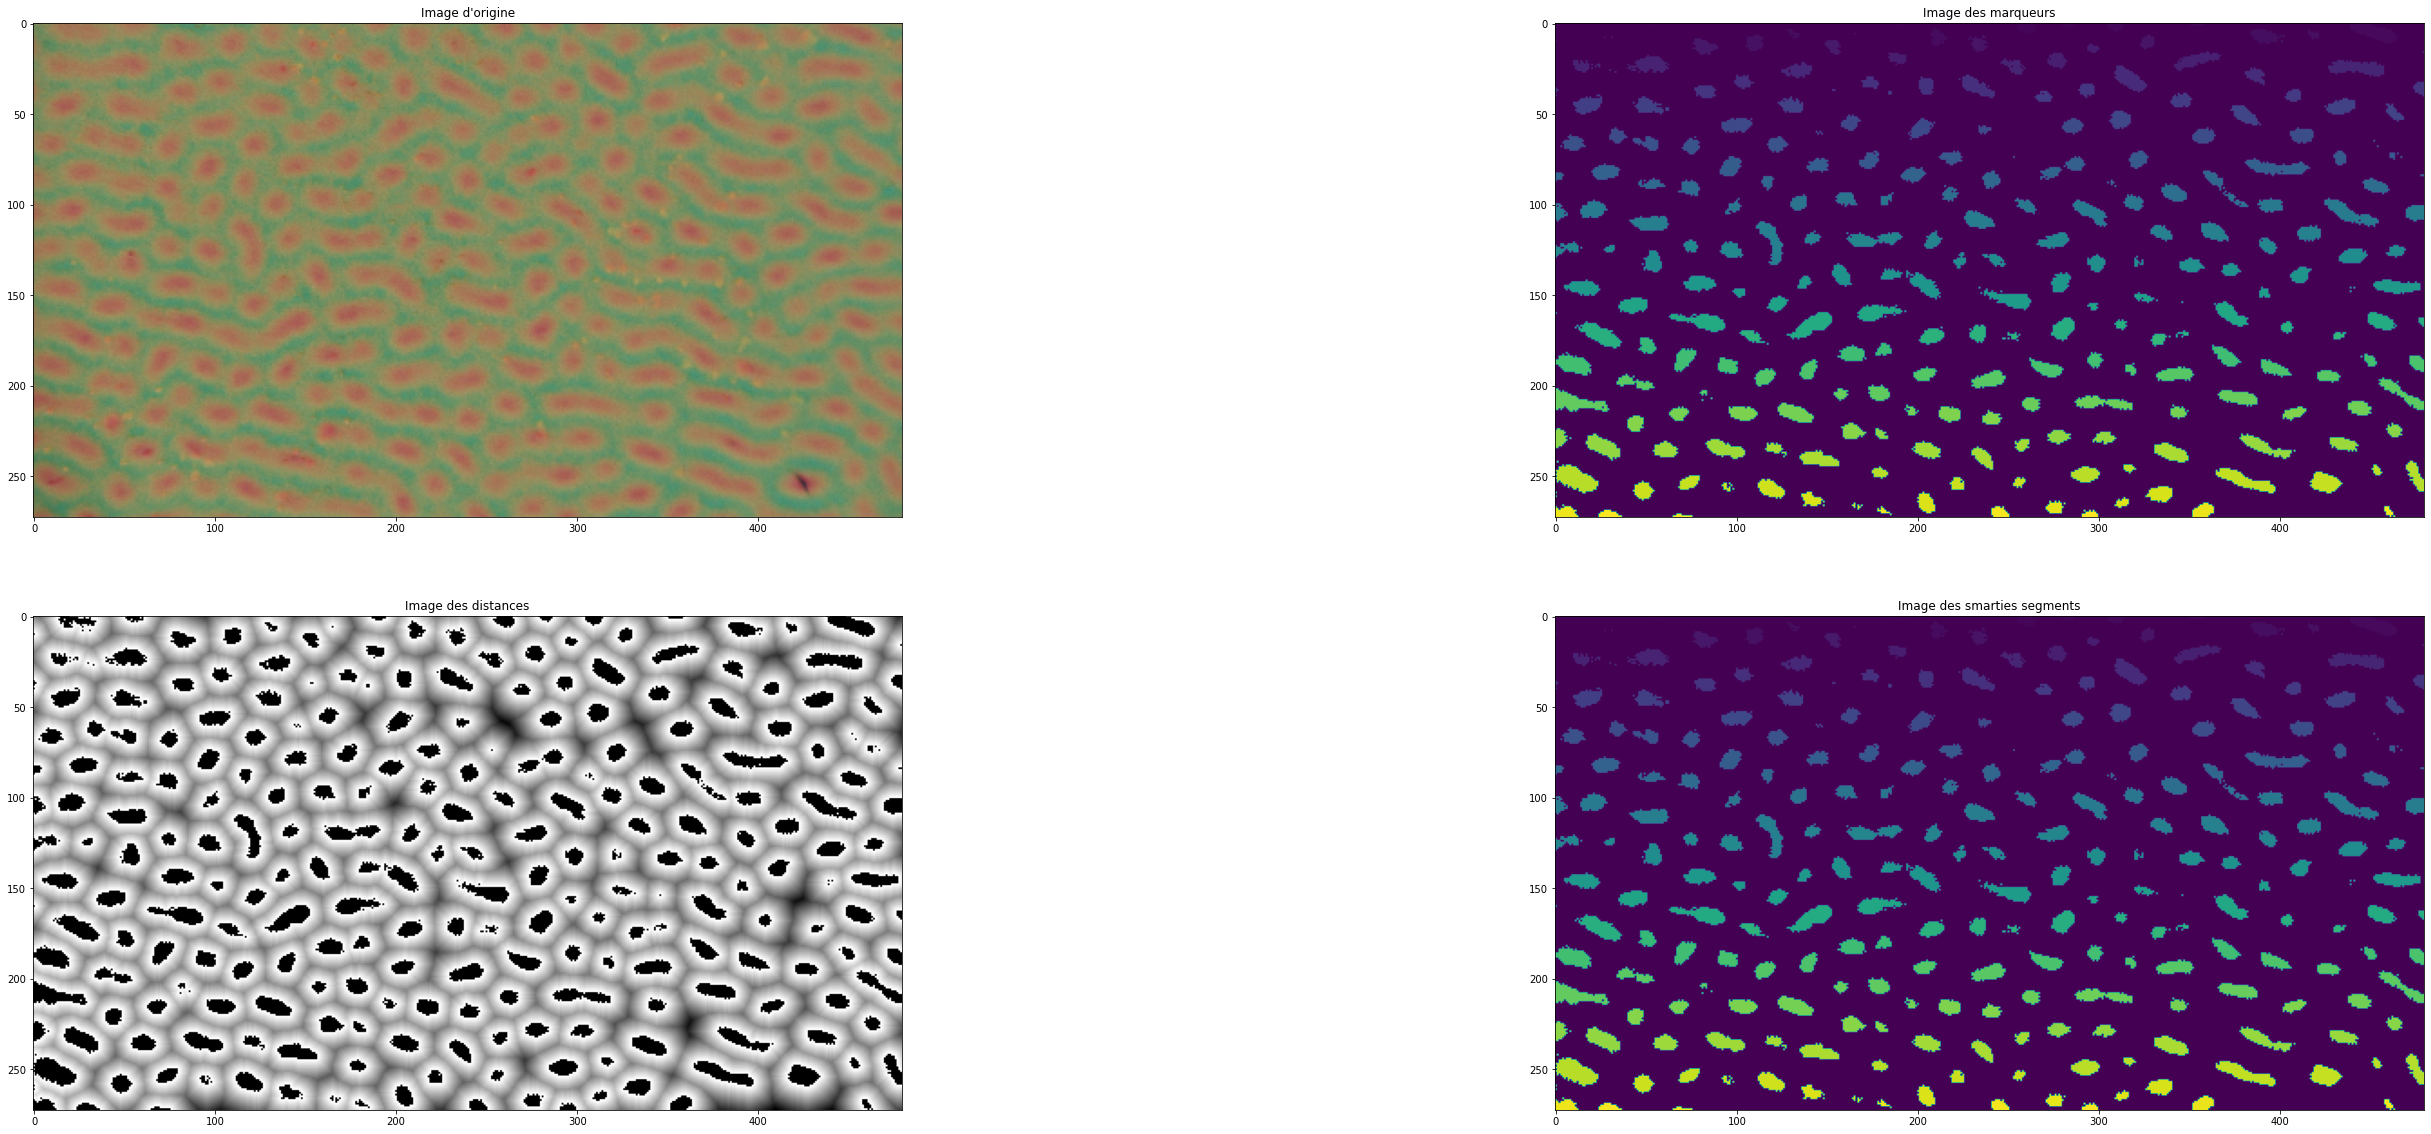

In [48]:
#initialisation de la FAH
FAH_x=[]
FAH_y=[]

image_smarties_segmentes=np.copy(image_finale)

for i in range(u+1):
    FAH_x.append([])
    FAH_y.append([])

ligne=image_finale.shape[0]
colonne=image_finale.shape[1]

for i in range (ligne):
    for j in range (colonne):
        if image_finale[i][j]!=0:
            FAH_x[image_finale2_norm_int[i][j]].append(i) #on va chercher le pixel a la position i,j dans image_finale2_norm_int. cette position est regarde dans l'image image_finale et si le pixel correspond a un marqueur on rajout a FAH.x l'abscice du marqueur par ordre de priorité
            FAH_y[image_finale2_norm_int[i][j]].append(j) #on va chercher le pixel a la position i,j dans image_finale2_norm_int. cette position est regarde dans l'image image_finale et si le pixel correspond a un marqueur on rajout a FAH.y l'ordonnée du marqueur par ordre de priorité

Nb_enregistre={0,50,100,150,200,255}
m=0 # se ddeplace dans FAH_x
while m!=u+1: #tant qu'on a pas parcouru toute la liste
    if FAH_x[m]: # si la coordonné x existe
        
        while FAH_x[m]: 
            i=FAH_x[m].pop(0) #on elenve la premiere valeur, cad celle qui a la priorité la plus grande
            j=FAH_y[m].pop(0)
            
            if (i< ligne -1): #calcul du voisin de droite
                if image_smarties_segmentes[i+1][j]==0: #sur l'image de marqueurs
                    image_smarties_segmentes[i+1][j]=image_smarties_segmentes[i][j] 
                    img= image_finale2_norm_int[i+1][j] #sur l'image des distances
                    FAH_x[np.max([img, m])].append(i+1)
                    FAH_y[np.max([img, m])].append(j)

            if (j< colonne -1): #calcul du voisin du bas
                if image_smarties_segmentes[i][j+1]==0:
                    image_smarties_segmentes[i][j+1]=image_smarties_segmentes[i][j]
                    img= image_finale2_norm_int[i][j+1]
                    FAH_x[np.max([img, m])].append(i)
                    FAH_y[np.max([img, m])].append(j+1)
                    
            if (i!=0): #calcul du voisin de gauche 
                if image_smarties_segmentes[i-1][j]==0:
                    image_smarties_segmentes[i-1][j]=image_smarties_segmentes[i][j]
                    img= image_finale2_norm_int[i-1][j]
                    FAH_x[np.max([img, m])].append(i-1)
                    FAH_y[np.max([img, m])].append(j)
                
            if (j!=0): #calcul du voisin de gauche 
                if image_smarties_segmentes[i][j-1]==0:
                    image_smarties_segmentes[i][j-1]=image_smarties_segmentes[i][j]
                    img= image_finale2_norm_int[i][j-1]
                    FAH_x[np.max([img, m])].append(i)
                    FAH_y[np.max([img, m])].append(j-1)
                
    else:
        if m in Nb_enregistre:
            image_smarties_segmentes_enregistre = plt.imsave("{}.png".format(m), image_smarties_segmentes)
        m=m+1
        



plt.figure(figsize=(50,20)) # ouvre une nouvelle figure

plt.subplot(221)
plt.title("Image d'origine")
plt.imshow(I,'gray')

plt.subplot(222)
plt.title("Image des marqueurs")
plt.imshow(image_finale)

plt.subplot(223)
plt.title("Image des distances")
plt.imshow(image_finale2_norm_int, 'gray')

plt.subplot(224)
plt.title('Image des smarties segments')
plt.imshow(image_smarties_segmentes)

plt.show()